In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import torch.nn
import torch.optim
import torch.utils.data
import mls.torch
from sklearn import model_selection, neighbors, tree, ensemble, preprocessing, cluster
from scipy.spatial import distance
from sklearn.neighbors import KernelDensity
import time

In [27]:
higgs_mass = 125.09
higgs_mass_sigma = 3.0

dm_relic_density = .11
dm_relic_density_sigma = .03

# Static Definitions

pmssm_parameters: {"m1": {"bounds": [[-4000.0, -50.0],[50.0, 4000.0]], "prior": "uniform", "type": "continuous"},
             "m2": {"bounds": [[-4000.0, -100.0],[100.0, 4000.0]], "prior": "uniform", "type": "continuous"},
             "m3": {"bounds": [400.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mmu": {"bounds": [[-4000.0, -100.0],[100.0, 4000.0]], "prior": "uniform", "type": "continuous"},
             "mA": {"bounds": [100.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "At": {"bounds": [-4000.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "Ab": {"bounds": [-4000.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "Atau": {"bounds": [-4000.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mL12": {"bounds": [100.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mL3": {"bounds": [100.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "me12": {"bounds": [100.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "me3": {"bounds": [100.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mQ12": {"bounds": [400.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mQ3": {"bounds": [200.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mu12": {"bounds": [400.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mu3": {"bounds": [200.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "md12": {"bounds": [400.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "md3": {"bounds": [200.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "tanb": {"bounds": [1.0, 60.0], "prior": "uniform", "type": "continuous"}
            }

cmssm_parameters: {"m1": {"bounds": [[0, -50.0],[50.0, 4000.0]], "prior": "uniform", "type": "continuous"},
             "m2": {"bounds": [[-4000.0, -100.0],[100.0, 4000.0]], "prior": "uniform", "type": "continuous"},
             "m3": {"bounds": [400.0, 4000.0], "prior": "uniform", "type": "continuous"},
             "mmu": {"bounds": [[-4000.0, -100.0],[100.0, 4000.0]], "prior": "uniform", "type": "continuous"},
             "mA": {"bounds": [100.0, 4000.0], "prior": "uniform", "type": "continuous"},
            }

cmssm_columns = ['gut_m0', 'gut_m12', 'gut_A0', 'gut_tanb', 'sign_mu']
pmssm_columns = ['gut_m1', 'gut_m2', 'gut_m3', 'gut_mmu', 'gut_mA', 'gut_Ab', 'gut_At', 'gut_Atau', 'gut_mL1',\
                 'gut_mL3', 'gut_me1', 'gut_mtau1', 'gut_mQ1', 'gut_mQ3', 'gut_mu1', 'gut_mu3', 'gut_md1', \
                 'gut_md3', 'gut_tanb']
weak_soft_columns = ['weak_Au', 'weak_Ac', 'weak_At','weak_Ad', 'weak_As', 'weak_Ab','weak_Ae', 'weak_Amu', \
                     'weak_Atau', 'weak_tanb', 'weak_gprime', 'weak_g2','weak_g3', 'weak_m1', 'weak_m2', \
                     'weak_m3', 'weak_mA2', 'weak_mmu', 'weak_mH12', 'weak_mH22', 'weak_muR','weak_mcR', \
                     'weak_mtR', 'weak_mdR','weak_msR', 'weak_mbR', 'weak_eR','weak_mmuR', 'weak_mtauR', \
                     'weak_mQ1','weak_mQ2', 'weak_mQ3', 'weak_mL1','weak_mL2', 'weak_mL3', 'weak_higgsvev', \
                     'weak_Yt', 'weak_Yb', 'weak_Ytau']
weak_mass_columns = ['weakm_mW', 'weakm_mh','weakm_mH','weakm_mA', 'weakm_mHpm','weakm_m3','weakm_mneut1', \
                     'weakm_mneut2','weakm_mneut3','weakm_mneut4','weakm_mcharg1','weakm_mcharg2','weakm_mdL',\
                     'weakm_muL','weakm_msL','weakm_mcL','weakm_mb1','weakm_mt1','weakm_meL','weakm_mesneuL',\
                     'weakm_mmuL','weakm_mmusneuL', 'weakm_mtau1','weakm_mtausneuL','weakm_mdR', 'weakm_muR',\
                     'weakm_msR','weakm_mcR', 'weakm_mb2','weakm_mt2','weakm_meR', 'weakm_mmuR','weakm_mtau2',\
                     'weakm_neutmix11','weakm_neutmix12', 'weakm_neutmix13','weakm_neutmix14']
weak_measurements_columns = ['omegah2', 'g-2', 'b->sgamma','b->sgammaSM', 'B+->taunu','Bs->mumu','Ds->taunu',\
                             'Ds->munu', 'deltarho', 'RL23', 'lspmass', 'sigmav','cdmpSI','cdmpSD','cdmnSI',\
                             'cdmnSD']
dm_channels_columns = ['chan1weight', 'chan1part1', 'chan1part2', 'chan1part3','chan1part4', \
                       'chan2weight', 'chan2part1', 'chan2part2', 'chan2part3','chan2part4', \
                       'chan3weight', 'chan3part1', 'chan3part2', 'chan3part3','chan3part4', \
                       'chan4weight', 'chan4part1', 'chan4part2', 'chan4part3','chan4part4', \
                       'chan5weight', 'chan5part1', 'chan5part2', 'chan5part3','chan5part4', \
                       'chan6weight', 'chan6part1', 'chan6part2', 'chan6part3','chan6part4', \
                       'chan7weight', 'chan7part1', 'chan7part2', 'chan7part3','chan7part4', \
                       'chan8weight', 'chan8part1', 'chan8part2', 'chan8part3','chan8part4', \
                       'chan9weight', 'chan9part1', 'chan9part2', 'chan9part3','chan9part4', \
                       'chan10weight', 'chan10part1', 'chan10part2', 'chan10part3','chan10part4']
gut_gauge_columns = ['gut_energscale', 'gut_gprime', 'gut_g2', 'gut_g3']



assert (len(cmssm_columns) == 5), "cmssm_columns wrong entries"
assert (len(pmssm_columns) == 19), "pmssm_columns wrong entries"
assert (len(weak_soft_columns) == 39), "weak_soft_columns wrong entries"
assert (len(weak_mass_columns) == 37), "weak_mass_columns wrong entries"
assert (len(weak_measurements_columns) == 16), "weak_measurements_columns wrong entries"
assert (len(dm_channels_columns) == 50), "dm_channels_columns wrong entries"
assert (len(gut_gauge_columns) == 4), "gut_gauge_columns wrong entries"

common_columns = weak_soft_columns + weak_mass_columns + weak_measurements_columns + dm_channels_columns \
                 + gut_gauge_columns

def constraints_cmssm(X):
    #neutralino_lsp = X['lspmass'] == X['weakm_mneut1']
    #relic_density_saturated = (X['omegah2'] - dm_relic_density).abs() < dm_relic_density_sigma
    #higgs = (X['weakm_mh'] - higgs_mass).abs() < higgs_mass_sigma
    #relic_density = relic_density_saturated
    # Require that sign_mu = 1, required to train normalizing flow.
    #sgn_mu = X['sign_mu'] == 1
   # X = X[neutralino_lsp]
    #X = X[relic_density]
    #X = X[higgs]
    return X

def constraints_pmssm(X):
    neutralino_lsp = X['lspmass'] == X['weakm_mneut1']
    relic_density_saturated = (X['omegah2'] - dm_relic_density).abs() < dm_relic_density_sigma
    higgs = (X['weakm_mh'] - higgs_mass).abs() < higgs_mass_sigma
    X = X[neutralino_lsp]
    X = X[relic_density_saturated]
    X = X[higgs]
    return X

def import_data_efficient(data_dir, subspace):
    '''
    Method to read in the SUSY datasets while minimizing memory usage. Selects only datapoints that satisfy constraints.

    Arguments:
        data_dir: string, path to the folder containing the csv files.
        constraints: A function that selects points to retain from the CSV file after being read into Pandas DF.
        subspace: 'cmssm' or'pmssm', specifies which dataset to read in.
    Returns:
        Numpy array containing the 'read_columns' entries in the dataset.
    '''
    # See the README file for a description of the file structure.
    if subspace == 'cmssm':
        all_columns = cmssm_columns + common_columns
        read_columns = all_columns
        constraints = constraints_cmssm
    if subspace == 'pmssm':
        all_columns = pmssm_columns + common_columns
        read_columns = all_columns
        constraints = constraints_pmssm
    filenames = np.array(os.listdir(data_dir))
    individual_files = []
    for filename in filenames:
        try:
            file_dataframe = pd.read_csv(data_dir + "/" + filename, sep=',', header=None, names=all_columns, usecols=[0,1,2,3,4,45,50,81,91])
            individual_files += [constraints(file_dataframe)]
        except:
            print(filename + ' threw an error')
    concatenated_files = pd.concat(individual_files)
    return concatenated_files.values

if __name__ == '__main__':
    import numpy as np
    import pandas as pd
    import os
    #import_data_efficient('/udd/dm_class_data/pmssm_rand', 'pmssm')

In [28]:
df = import_data_efficient('/Users/jasonbaretz/Downloads/cmssm_random_new', 'cmssm')
#df2 = pd.read_csv('/Users/jasonbaretz/Desktop/reversespaces/posttoy/datagen/ran_points_0.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
#df3 = pd.read_csv('/Users/jasonbaretz/Desktop/reversespaces/posttoy/it1/ran_points_0.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
#df4 = pd.read_csv('/Users/jasonbaretz/Desktop/reversespaces/posttoy/it2nonkde/ran_points_0.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
#df5 = pd.read_csv('/Users/jasonbaretz/Desktop/reversespaces/posttoy/it3wideband/ran_points_0.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
#df6 = pd.read_csv('/Users/jasonbaretz/Desktop/reversespaces/posttoy/it4wideband/ran_points_0.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
#df7 = pd.read_csv('/Users/jasonbaretz/Desktop/reversespaces/posttoy/it5nonkde/ran_points_0.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
#df8 = pd.read_csv('/Users/jasonbaretz/Desktop/New_Dense_Data_CMSSM.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])

In [29]:
#data generation:
# KDE original triple valids: 20k pts
# for each pt gen. 5 dm vals
# for each pt filter for all valid points with near-DM value
# calc distance of pt - valid pt for each and find argmin
# append to list(KDE pt, gen DM val, KDE pt-correct pt)


In [30]:
df8 = pd.read_csv('/Users/jasonbaretz/Desktop/New_Dense_Data_CMSSM.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])
df9 = pd.read_csv('/Users/jasonbaretz/Desktop/New_Dense_Data_CMSSM_redux.txt', sep=',', header=None, names=None, usecols=[0,1,2,3,4,45,50,81,91])


In [31]:
print(np.shape(df))
print(np.shape(df8))
print(np.shape(df9))

(10307273, 9)
(520000, 9)
(180000, 9)


In [32]:
def boxcarpy(x,val=125.09,sigma=3.0,mode='reg'):
    low = torch.tensor([val - sigma])
    hi =  torch.tensor([val + sigma])
    if mode == 'reg':
        return -torch.heaviside(x-hi, torch.tensor([1.0])) + torch.heaviside(x-low, torch.tensor([1.0]))
    elif mode == 'anti':
        return torch.tensor([1.0]) + torch.heaviside(x-hi, torch.tensor([1.0])) - torch.heaviside(x-low, torch.tensor([1.0]))

In [33]:
torchtest1 = torch.from_numpy(df.astype('float32'))
#torchtest2 = torch.from_numpy(df2.to_numpy().astype('float32'))
#torchtest3 = torch.from_numpy(df3.to_numpy().astype('float32'))
#torchtest4 = torch.from_numpy(df4.to_numpy().astype('float32'))
#torchtest5 = torch.from_numpy(df5.to_numpy().astype('float32'))
#torchtest6 = torch.from_numpy(df6.to_numpy().astype('float32'))
#torchtest7 = torch.from_numpy(df7.to_numpy().astype('float32'))
torchtest8 = torch.from_numpy(df8.to_numpy().astype('float32'))
torchtest9= torch.from_numpy(df9.to_numpy().astype('float32'))
#torchtest = torch.cat((torchtest1,torchtest2,torchtest3,torchtest4,torchtest5,torchtest6,torchtest7,torchtest8),0)
torchtest2=torch.cat((torchtest1,torchtest8,torchtest9),0)
#.to_numpy()

In [34]:
#torchtest

In [35]:
#vtrain = torch.squeeze(torchtest[[boxcarpy(torchtest[:,5]).nonzero()]])
#vdtrain = torch.squeeze(vtrain[[boxcarpy(vtrain[:,7],val=0.11,sigma=0.03).nonzero()]])
#vttrain = torch.squeeze(vdtrain[[(vdtrain[:,6]==vdtrain[:,8]).nonzero()]])
#wdtrain = torch.squeeze(vtrain[[boxcarpy(vtrain[:,7],val=0.5,sigma=0.5).nonzero()]])
#wttrain = torch.squeeze(wdtrain[[(wdtrain[:,6]==wdtrain[:,8]).nonzero()]])

In [36]:
vtrain2 = torch.squeeze(torchtest2[[boxcarpy(torchtest2[:,5]).nonzero()]])
vdtrain2 = torch.squeeze(vtrain2[[boxcarpy(vtrain2[:,7],val=0.11,sigma=0.03).nonzero()]])
vttrain2 = torch.squeeze(vdtrain2[[(vdtrain2[:,6]==vdtrain2[:,8]).nonzero()]])
wdtrain2 = torch.squeeze(vtrain2[[boxcarpy(vtrain2[:,7],val=0.5,sigma=0.5).nonzero()]])
wttrain2 = torch.squeeze(wdtrain2[[(wdtrain2[:,6]==wdtrain2[:,8]).nonzero()]])

In [37]:
vtrainO = torch.squeeze(torchtest1[[boxcarpy(torchtest1[:,5]).nonzero()]])
vdtrainO = torch.squeeze(vtrainO[[boxcarpy(vtrainO[:,7],val=0.11,sigma=0.03).nonzero()]])
vttrainO = torch.squeeze(vdtrainO[[(vdtrainO[:,6]==vdtrainO[:,8]).nonzero()]])
wdtrainO = torch.squeeze(vtrainO[[boxcarpy(vtrainO[:,7],val=0.5,sigma=0.5).nonzero()]])
wttrainO = torch.squeeze(wdtrainO[[(wdtrainO[:,6]==wdtrainO[:,8]).nonzero()]])
print(vttrainO.size())
print(vdtrainO.size())

torch.Size([4488, 9])
torch.Size([46047, 9])


In [38]:
print(vttrain2.size())
print(vdtrain2.size())

torch.Size([187590, 9])
torch.Size([229676, 9])


In [39]:
minvec = vttrainO.detach().numpy().min(axis=0)
maxvec = vttrainO.detach().numpy().max(axis=0)
print(minvec)
print(maxvec)

[ 3.45325e+02  2.39913e+01 -2.48205e+04  3.59026e+00 -1.00000e+00
  1.22090e+02  1.02237e+00  8.00094e-02  1.02237e+00]
[9.99988e+03 4.83811e+03 3.33273e+04 4.99943e+01 1.00000e+00 1.27966e+02
 2.23235e+03 1.39975e-01 2.23235e+03]


In [40]:
minvec[5]=122.09
minvec[7]=0.08
maxvec[5]=128.09
maxvec[7]=0.14
print(minvec)
print(maxvec)

[ 3.45325e+02  2.39913e+01 -2.48205e+04  3.59026e+00 -1.00000e+00
  1.22090e+02  1.02237e+00  8.00000e-02  1.02237e+00]
[9.99988e+03 4.83811e+03 3.33273e+04 4.99943e+01 1.00000e+00 1.28090e+02
 2.23235e+03 1.40000e-01 2.23235e+03]


In [41]:
standVD = (vdtrainO - minvec)/(maxvec - minvec)
standVT = (vttrainO - minvec)/(maxvec - minvec)
bigstandVD=(vdtrain2 - minvec)/(maxvec - minvec)
bigstandVT=(vttrain2 - minvec)/(maxvec - minvec)

In [ ]:
cdf1

In [42]:
#kdec1 = KernelDensity(kernel="tophat", bandwidth=0.1).fit(standVT.detach().numpy())
#kdesamp= torch.tensor(kdec1.sample(n_samples=50000).astype('float32')) 
            

In [43]:
print(standVT)

tensor([[0.8083, 0.2401, 0.5361,  ..., 0.2256, 0.8446, 0.2256],
        [0.9233, 0.6086, 0.5299,  ..., 0.4298, 0.2070, 0.4298],
        [0.6719, 0.0836, 0.4722,  ..., 0.0791, 0.5986, 0.0791],
        ...,
        [0.8309, 0.0754, 0.5430,  ..., 0.0658, 0.3203, 0.0658],
        [0.4042, 0.0477, 0.4657,  ..., 0.0406, 0.4614, 0.0406],
        [0.7216, 0.4784, 0.4685,  ..., 0.4480, 0.9571, 0.4480]])


In [44]:
kdec2 = KernelDensity(kernel="tophat", bandwidth=0.1).fit(standVT[:,:5].detach().numpy())
kdebigsamp = torch.tensor(kdec2.sample(n_samples=300000).astype('float32')) 

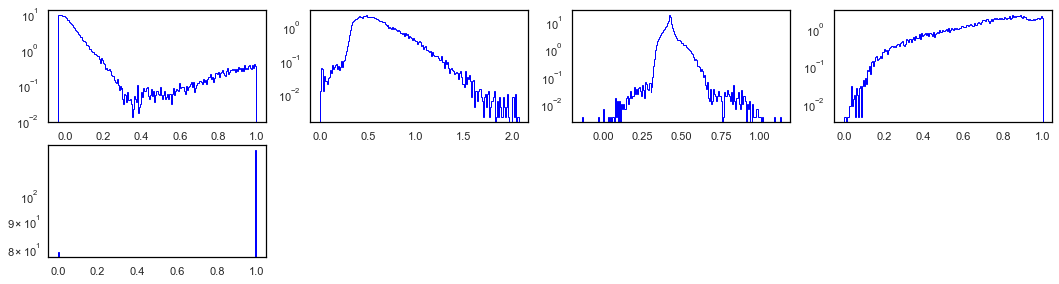

In [45]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
logv=True
for x in range(5):
        plt.subplot(5, 4, x+1)
        plt.hist(standVD[:,x].detach().numpy(),histtype='step', bins=200,color='blue',density=True,log=logv)
        plt.show

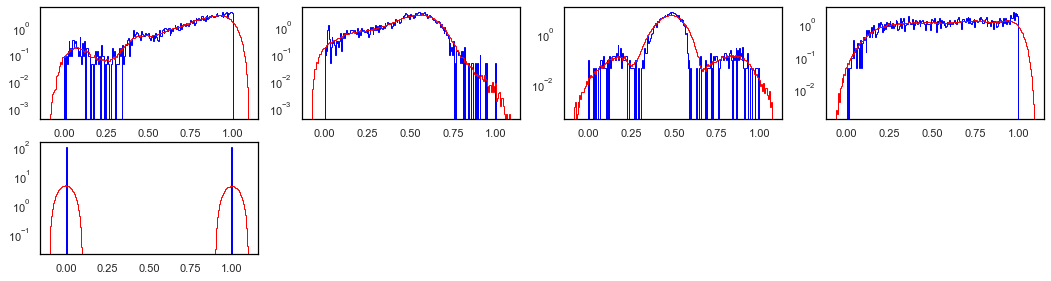

In [46]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
logv=True
for x in range(5):
        plt.subplot(5, 4, x+1)
        plt.hist(standVT[:,x].detach().numpy(),histtype='step', bins=200,color='blue',density=True,log=logv)
        plt.hist(kdebigsamp[:,x].detach().numpy(),histtype='step', bins=200,color='red',density=True,log=logv)
        plt.show

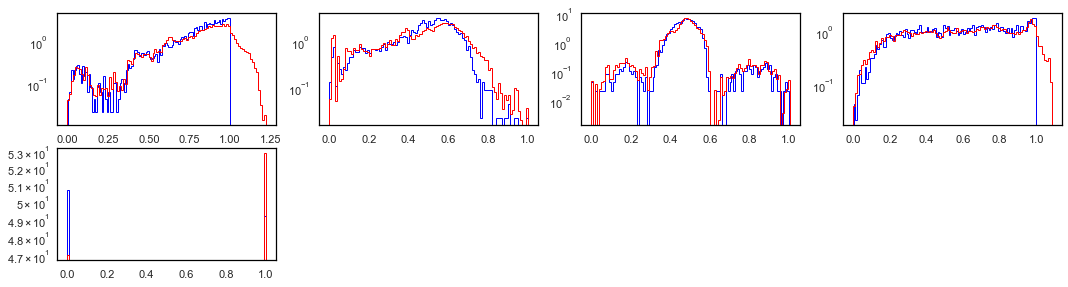

In [50]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
logv=True
for x in range(5):
        plt.subplot(5, 4, x+1)
        plt.hist(standVT[:,x].detach().numpy(),histtype='step', bins=100,color='blue',density=True,log=logv)
        plt.hist(bigstandVT[:,x].detach().numpy(),histtype='step', bins=100,color='red',density=True,log=logv)
        plt.show

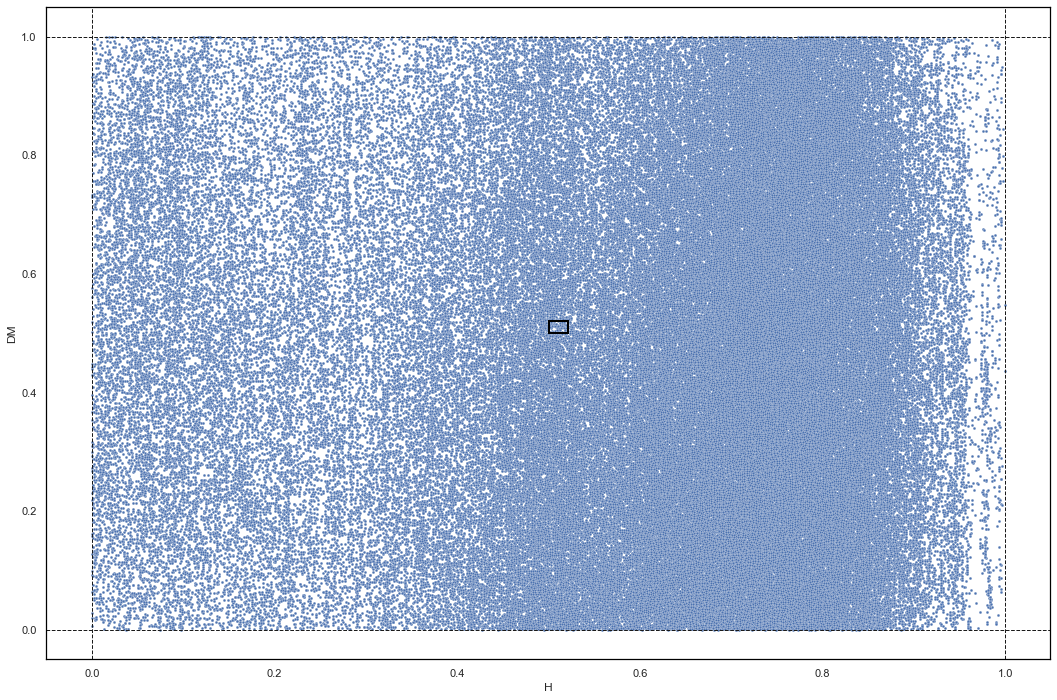

In [47]:
import matplotlib.patches as mpatches
clistb =["H", "LSP1","DM","LSP2"]
cdf1 = pd.DataFrame(bigstandVT[:,5:].numpy(),columns=clistb)
sz=8
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
sns.scatterplot(data = cdf1, x = "H", y = "DM", color='b',s=sz)
left, bottom, width, height = (0.5, 0.5, 1/48, 1/48)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="black",
                       linewidth=2)
plt.gca().add_patch(rect)
plt.axhline(0.0, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.0, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.0, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.0, color='k', linestyle='dashed', linewidth=1)
plt.show()

In [48]:
gutwk=torch.hstack((bigstandVT[:,:6],torch.unsqueeze(bigstandVT[:,7],1)))
cdf1 = pd.DataFrame(gutwk.detach().numpy())
cdf1.to_csv(r'/Users/jasonbaretz/Downloads/triple_valid_dataset.txt',header=False,index=False)




In [23]:
class cornet(torch.nn.Module):
    
    def __init__(self, n_data=7, n_out=5,dval=75):
        super(cornet, self).__init__()
        self.n_out = n_out
        self.n_data=n_data
        # The posterior inference calculates (z) for the posterior probability
        # of a sample in the latent space.
        self.predict = torch.nn.Sequential(torch.nn.Linear(7, dval*n_data), 
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),                                                                
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data,  n_out),)
     
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),  
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
    
    
    def correct(self, x):
        return self.predict(x)                                         
    
   
    def learn(self, data, n_epochs=100, batch_size=250,nw=0, learning_rate=0.0001,tcon=10, lrm=10, n_print=1,mode=None,switch='NO',swn=100,benchv=0.00281):
        print(f'Model has {np.sum([np.prod(P.shape) for P in self.parameters()])} parameters.')
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True,num_workers=nw)
        print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
        optimizera = torch.optim.Adam(self.parameters(), lr=learning_rate,amsgrad=True)
        optimizerb = torch.optim.SGD(self.parameters(), lr=lrm*learning_rate)
        optimizer=optimizera
        print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
        losses = []
        testloss=[]
        bench=benchv
        self.train()
        l2_loss = torch.nn.MSELoss(reduction='mean')
        if mode=='SAVE':
            print('SAVEMODE')
        testsamp=datalist3[torch.randint(high = datalist3.size(0), size =(tcon*batch_size,))]
        for epoch in range(n_epochs):
            tcor=self.correct(testsamp[:,:7])
            tloss=l2_loss(testsamp[:,7:],  tcor)
            testloss.append(float(tloss.data))
            if tloss<bench:
                savestring= "/Users/jasonbaretz/Desktop/trainsave/CORHDM/modelcorHDMmini_epoch_"+str(epoch)+"_TESTloss_"+str(tloss.item())+".pt"
                torch.save(self.state_dict(), savestring)
                bench=tloss
            if epoch == swn:
                if switch=='YES':
                    optimizer=optimizerb
                    print('Optimizer Change')
            for x_train, _ in loader:  
                xcor=self.correct(x_train[:,:7])
                loss=l2_loss(x_train[:,7:],  xcor)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()                           
            losses.append(float(loss.data))
            if epoch + 1 == print_at[0] or epoch==0:
                print(f'EPOCH {epoch + 1:5d}:  L2LOSS {losses[-1]:.5f} TESTLOSS {testloss[-1]:.5f}')
                if epoch !=0: 
                    print_at = print_at[1:]
                if mode=='SAVE':
                    savestring= "/Users/jasonbaretz/Desktop/trainsave/CORHDM/modelcorHDMmini_epoch_"+str(epoch+1)+"_loss_"+str(loss.item())+".pt"
                    torch.save(self.state_dict(), savestring)
        plt.figure(figsize=(10, 5))                                                                  
        plt.plot(losses, '.',color='black', label='TOTAL')
        plt.plot(testloss, '.',color='blue', label='TESTLOSS')
        if switch=='YES':
            plt.axvline(swn, color='k', linestyle='dashed', linewidth=1)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Losses')
        plt.yscale('log')
        plt.legend()
        return losses,testloss

In [ ]:
class smartit(torch.nn.Module):
    
    def __init__(self, n_data=7, n_out=1,dval=75):
        super(smartit, self).__init__()
        self.n_out = n_out
        self.n_data=n_data
        # The posterior inference calculates (z) for the posterior probability
        # of a sample in the latent space.
        self.predict = torch.nn.Sequential(torch.nn.Linear(7, dval*n_data), 
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),                                                                
            torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data,  n_out),)
     
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),  
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data),
            #torch.nn.LeakyReLU(0.2, inplace=True), torch.nn.Linear(dval*n_data, dval*n_data), 
      
    def correct(self, x):
        return self.predict(x)                                         
    
    def learn(self, data, n_epochs=100, batch_size=250,nw=0, learning_rate=0.0001,tcon=10, lrm=10, n_print=1,mode=None,switch='NO',swn=100,benchv=0.00281):
        print(f'Model has {np.sum([np.prod(P.shape) for P in self.parameters()])} parameters.')
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True,num_workers=nw)
        print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
        optimizera = torch.optim.Adam(self.parameters(), lr=learning_rate,amsgrad=True)
        optimizerb = torch.optim.SGD(self.parameters(), lr=lrm*learning_rate)
        optimizer=optimizera
        print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
        losses = []
        testloss=[]
        bench=benchv
        self.train()
        l2_loss = torch.nn.MSELoss(reduction='sum')
        if mode=='SAVE':
            print('SAVEMODE')
        testsamp=torch.from_numpy(X_testtot)
        testsamp = testsamp.to(device)
        for epoch in range(n_epochs):
            tcor=self.correct(testsamp[:,:7])
            accept= testsamp[:,7:]==torch.round(tcor)
            pvals = torch.squeeze(testsamp[:,7:][[(torch.logical_not(accept))).nonzero()]])
            punish = torch.squeeze(tcor[[(torch.logical_not(accept))).nonzero()]])
            tloss=l2_loss(punish,  pvals)
            testloss.append(float(tloss.data))
            if tloss<bench:
                savestring= "/DFS-L/DATA/whiteson/jbaretz/trainsave_overflow/modelsmitHDM_epoch_"+str(epoch)+"_TESTloss_"+str(tloss.item())+".pt"
                torch.save(self.state_dict(), savestring)
                bench=tloss
            if epoch == swn:
                if switch=='YES':
                    optimizer=optimizerb
                    print('Optimizer Change')
            for x_train, _ in loader:
                x_train = x_train.to(device)
                xcor=self.correct(x_train[:,:7])
                accept= x_train[:,7:]==torch.round(xcor)
                xpvals = torch.squeeze(x_train[:,7:][[(torch.logical_not(accept))).nonzero()]])
                xpunish = torch.squeeze(xcor[[(torch.logical_not(accept))).nonzero()]])
                loss=l2_loss(xpunish,  xpvals)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()                           
            losses.append(float(loss.data))
            if epoch + 1 == print_at[0] or epoch==0:
                print(f'EPOCH {epoch + 1:5d}:  L2LOSS {losses[-1]:.5f} TESTLOSS {testloss[-1]:.5f}')
                if epoch !=0: 
                    print_at = print_at[1:]
                if mode=='SAVE':
                    savestring= "/DFS-L/DATA/whiteson/jbaretz/trainsave_overflow/modelsmitHDM_epoch_"+str(epoch+1)+"_loss_"+str(loss.item())+".pt"
                    torch.save(self.state_dict(), savestring)
        plt.figure(figsize=(10, 5))                                                                  
        plt.plot(losses, '.',color='black', label='TOTAL')
        plt.plot(testloss, '.',color='blue', label='TESTLOSS')
        if switch=='YES':
            plt.axvline(swn, color='k', linestyle='dashed', linewidth=1)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Losses')
        plt.yscale('log')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))                                                                  
        plt.plot(losses, '.',color='black', label='TOTAL')
        plt.plot(testloss, '.',color='blue', label='TESTLOSS')
        if switch=='YES':
            plt.axvline(swn, color='k', linestyle='dashed', linewidth=1)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Losses')
        plt.yscale('log')
        plt.legend()
        plt.savefig('/export/nfs0home/jbaretz/smit_loss.png')
        return losses,testloss

In [24]:
print('goodtogo')

goodtogo


In [25]:
def inoutplot(samps):
    all_columns = cmssm_columns + common_columns
    sns.set(font_scale=2)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    ptsback = pd.read_csv('/Users/jasonbaretz/Desktop/RunCoupOutput/ran_points_0.txt', sep=',', header=None, names=all_columns, usecols=all_columns)
    #read in points as pandas dataframe, then convert to numpy array
    numbpts = ptsback.to_numpy()
    #take higgs mass slice (column 45 for cmssm higgs) and turn to torch tensor
    hvals = torch.from_numpy(numbpts[:,45].astype('float32'))
    dmvals = torch.from_numpy(numbpts[:,81].astype('float32'))
    hmax = maxvec[5]
    hmin = minvec[5]
    dmmax = maxvec[7]
    dmmin = minvec[7]
    hsampsn=hmin + (hmax - hmin)*samps[:,0]
    dmsampsn=dmmin + (dmmax - dmmin)*samps[:,1]
    h2x2= torch.hstack((torch.unsqueeze(torch.tensor(hsampsn), 1),torch.unsqueeze(hvals, 1)))
    dm2x2= torch.hstack((torch.unsqueeze(torch.tensor(dmsampsn), 1),torch.unsqueeze(dmvals, 1)))
    dfh22 = pd.DataFrame(h2x2.detach().numpy(),columns=["Hin", "Hout"])
    dfdm22 = pd.DataFrame(dm2x2.detach().numpy(),columns=["DMin", "DMout"])
    sns.scatterplot(data = dfh22, x = "Hin", y = "Hout",alpha=0.6)
    plt.axhline(122.09, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(125.09, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(128.09, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(122.09, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(125.09, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(128.09, color='k', linestyle='dashed', linewidth=1)
    plt.axline((0,0), slope=1,color='k', linestyle='dashed', linewidth=1)
    plt.xlim([119.09, 131.09])
    plt.ylim([119.09, 131.09])
    plt.show()
    sns.scatterplot(data = dfdm22, x = "DMin", y = "DMout",alpha=0.6)
    plt.axhline(0.08, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.11, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.14, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(0.08, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(0.11, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(0.14, color='k', linestyle='dashed', linewidth=1)
    plt.axline((0,0), slope=1,color='k', linestyle='dashed', linewidth=1)
    plt.xlim([0.05, 0.17])
    plt.ylim([0.05, 0.17])
    plt.show()
    lp1=sns.scatterplot(data = dfh22, x = "Hin", y = "Hout",alpha=0.6)
    lp1.set(yscale="log")
    plt.axhline(122.09, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(125.09, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(128.09, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(122.09, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(125.09, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(128.09, color='k', linestyle='dashed', linewidth=1)
    plt.show()
    lp2=sns.scatterplot(data = dfdm22, x = "DMin", y = "DMout",alpha=0.6)
    lp2.set(yscale="log")
    plt.axhline(0.08, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.11, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.14, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(0.08, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(0.11, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(0.14, color='k', linestyle='dashed', linewidth=1)
    plt.show()

In [26]:
def disterrplot(corrs,samps):
    all_columns = cmssm_columns + common_columns
    sns.set(font_scale=4)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    ptsback = pd.read_csv('/Users/jasonbaretz/Desktop/RunCoupOutput/ran_points_0.txt', sep=',', header=None, names=all_columns, usecols=all_columns)
    #read in points as pandas dataframe, then convert to numpy array
    numbpts = ptsback.to_numpy()
    #take higgs mass slice (column 45 for cmssm higgs) and turn to torch tensor
    hvals = torch.from_numpy(numbpts[:,45].astype('float32'))
    dmvals = torch.from_numpy(numbpts[:,81].astype('float32'))
    hmax = maxvec[5]
    hmin = minvec[5]
    dmmax = maxvec[7]
    dmmin = minvec[7]
    hsampsn=hmin + (hmax - hmin)*samps[:,0]
    dmsampsn=dmmin + (dmmax - dmmin)*samps[:,1]
    herr= torch.abs(hsampsn-hvals)
    dmerr= torch.abs(dmsampsn-dmvals)
    distls= torch.linalg.norm(corrs, dim=1)
    herrdx= torch.hstack((torch.unsqueeze(torch.tensor(herr), 1),torch.unsqueeze(distls, 1)))
    dmerrdx= torch.hstack((torch.unsqueeze(torch.tensor(dmerr), 1),torch.unsqueeze(distls, 1)))
    dfhder = pd.DataFrame(herrdx.detach().numpy(),columns=["H_err", "Cor_Dist"])
    dfdmder = pd.DataFrame(dmerrdx.detach().numpy(),columns=["DM_err", "Cor_Dist"])
    
    sns.scatterplot(data = dfhder, x = "H_err", y = "Cor_Dist",alpha=0.6)
    plt.show()
    sns.scatterplot(data = dfdmder, x = "DM_err", y = "Cor_Dist",alpha=0.6)
    plt.show()
    lp1=sns.scatterplot(data = dfhder, x = "H_err", y = "Cor_Dist",alpha=0.6)
    lp1.set(yscale="log")
    lp1.set(xscale="log")
    plt.show()
    lp2=sns.scatterplot(data = dfdmder, x = "DM_err", y = "Cor_Dist",alpha=0.6)
    lp2.set(yscale="log")
    lp2.set(xscale="log")
    plt.axvline(0.01, color='k', linestyle='dashed', linewidth=1)
    plt.show()

In [27]:
def weakerrplot(samps,pal='viridis'):
    all_columns = cmssm_columns + common_columns
    sns.set(font_scale=4)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    ptsback = pd.read_csv('/Users/jasonbaretz/Desktop/RunCoupOutput/ran_points_0.txt', sep=',', header=None, names=all_columns, usecols=all_columns)
    #read in points as pandas dataframe, then convert to numpy array
    numbpts = ptsback.to_numpy()
    #take higgs mass slice (column 45 for cmssm higgs) and turn to torch tensor
    hvals = torch.from_numpy(numbpts[:,45].astype('float32'))
    dmvals = torch.from_numpy(numbpts[:,81].astype('float32'))
    hmax = maxvec[5]
    hmin = minvec[5]
    dmmax = maxvec[7]
    dmmin = minvec[7]
    hsampsn=hmin + (hmax - hmin)*samps[:,0]
    dmsampsn=dmmin + (dmmax - dmmin)*samps[:,1]
    herr= torch.abs(hsampsn-hvals)
    logdmerr= torch.log10(torch.abs(dmsampsn-dmvals))
    hdmerr= torch.hstack((torch.unsqueeze(torch.tensor(herr), 1),torch.unsqueeze(torch.tensor(logdmerr), 1)))
    hdmsamps= torch.hstack((torch.unsqueeze(hsampsn, 1),torch.unsqueeze(dmsampsn, 1)))
    errsamps=torch.hstack((hdmsamps,hdmerr))
    dfersa = pd.DataFrame(errsamps.detach().numpy(),columns=["Hval","DMval","H_err", "lDM_err"])
    ax=sns.scatterplot(data = dfersa, x = "Hval", y = "DMval",hue='H_err', palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa['H_err'].min(), dfersa['H_err'].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "Hval", y = "DMval",hue='lDM_err',palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa['lDM_err'].min(), dfersa['lDM_err'].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()

In [28]:
def guterrplot(samps,pal='viridis'):
    all_columns = cmssm_columns + common_columns
    sns.set(font_scale=4)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    ptsback = pd.read_csv('/Users/jasonbaretz/Desktop/RunCoupOutput/ran_points_0.txt', sep=',', header=None, names=all_columns, usecols=all_columns)
    #read in points as pandas dataframe, then convert to numpy array
    numbpts = ptsback.to_numpy()
    #take higgs mass slice (column 45 for cmssm higgs) and turn to torch tensor
    hvals = torch.from_numpy(numbpts[:,45].astype('float32'))
    dmvals = torch.from_numpy(numbpts[:,81].astype('float32'))
    hmax = maxvec[5]
    hmin = minvec[5]
    dmmax = maxvec[7]
    dmmin = minvec[7]
    hsampsn=hmin + (hmax - hmin)*samps[:,0]
    dmsampsn=dmmin + (dmmax - dmmin)*samps[:,1]
    herr= torch.abs(hsampsn-hvals)
    logdmerr= torch.log10(torch.abs(dmsampsn-dmvals))
    hdmerr= torch.hstack((torch.unsqueeze(torch.tensor(herr), 1),torch.unsqueeze(torch.tensor(logdmerr), 1)))
    hdmsamps= torch.hstack((torch.unsqueeze(hsampsn, 1),torch.unsqueeze(dmsampsn, 1)))
    errsamps=torch.hstack((torch.from_numpy(numbpts[:,:5].astype('float32')),hdmerr))
    dfersa = pd.DataFrame(errsamps.detach().numpy(),columns=["x0", "x1","x2","x3","x4","H_err", "lDM_err"])
    
    plt.rcParams["figure.figsize"] = (18,12)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    print('COLORED BY H ERROR')
    hv="H_err"
    ax=sns.scatterplot(data = dfersa, x = "x0", y = "x1", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x0", y = "x2", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x0", y = "x3", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x1", y = "x2", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x1", y = "x3", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x2", y = "x3", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    
    print('COLORED BY LOG DM ERROR')
    hv="lDM_err"
    ax=sns.scatterplot(data = dfersa, x = "x0", y = "x1", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x0", y = "x2", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x0", y = "x3", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x1", y = "x2", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x1", y = "x3", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()
    ax=sns.scatterplot(data = dfersa, x = "x2", y = "x3", hue=hv,palette=pal, alpha=0.6)
    norm = plt.Normalize(dfersa[hv].min(), dfersa[hv].max())
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()

    

In [29]:
def triplecheck(torchtest01):
    vtrain01 = torch.squeeze(torchtest01[[boxcarpy(torchtest01[:,5]).nonzero()]])
    vdtrain01 = torch.squeeze(vtrain01[[boxcarpy(vtrain01[:,7],val=0.11,sigma=0.03).nonzero()]])
    vttrain01 = torch.squeeze(vdtrain01[[(vdtrain01[:,6]==vdtrain01[:,8]).nonzero()]])
    return vttrain01

def histplotp(pathlist):
    holdlist = []
    all_columns = cmssm_columns + common_columns
    for x in pathlist:
        ptdf1 = pd.read_csv(x, sep=',', header=None, names=all_columns, usecols=[0,1,2,3,4,45,50,81,91])
        torchtest01 = torch.from_numpy(ptdf1.to_numpy().astype('float32'))
        holdlist.append(triplecheck(torchtest01).detach().numpy())
    colorlist=['blue','red','orange','magenta','yellow','black','pink']
    colorlist2 = colorlist[:len(pathlist)]
    for n in range(5):
        count2=0
        for y in holdlist:
            plt.hist(y[:,n],histtype='step', bins=100,density=True,log=True,color=colorlist2[count2]) 
            count2+=1
        plt.show()
 
        

In [30]:
def errhist(samps,mode='compare'):
    all_columns = cmssm_columns + common_columns
    sns.set(font_scale=4)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    ptsback = pd.read_csv('/Users/jasonbaretz/Desktop/RunCoupOutput/ran_points_0.txt', sep=',', header=None, names=all_columns, usecols=all_columns)
    #read in points as pandas dataframe, then convert to numpy array
    numbpts = ptsback.to_numpy()
    #take higgs mass slice (column 45 for cmssm higgs) and turn to torch tensor
    hvals = torch.from_numpy(numbpts[:,45].astype('float32'))
    dmvals = torch.from_numpy(numbpts[:,81].astype('float32'))
    hmax = maxvec[5]
    hmin = minvec[5]
    dmmax = maxvec[7]
    dmmin = minvec[7]
    hsampsn=hmin + (hmax - hmin)*samps[:,0]
    dmsampsn=dmmin + (dmmax - dmmin)*samps[:,1]
    herr= torch.abs(hsampsn-hvals)
    dmerr= torch.abs(dmsampsn-dmvals)
    if mode=='auto':
        dmminlogbin= torch.floor(torch.log10(torch.min(dmerr))).detach().numpy()
        dmmaxlogbin= torch.ceil(torch.log10(torch.max(dmerr))).detach().numpy()
    else:
        dmminlogbin=-6
        dmmaxlogbin=6
    print('HIGGS ERR:')
    plt.hist(herr.detach().numpy(),histtype='step', bins=200,log=True,color='black')
    plt.show()
    print('DM ERR:')
    plt.hist(dmerr.detach().numpy(),histtype='step', bins=np.logspace(dmminlogbin,dmmaxlogbin, 200),log=True,color='black')
    plt.xscale('log')
    plt.axvline(0.01, color='k', linestyle='dashed', linewidth=1)

    

In [32]:
print('good')

good


In [33]:
str4='/Users/jasonbaretz/Downloads/modelcorHDM_epoch_385_loss_0.001610639039427042.pt'
modelcorHDM = cornet(dval=200)
modelcorHDM.load_state_dict(torch.load(str4,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
str5='/Users/jasonbaretz/Downloads/STRINGHERE'
modelsmitHDM = smartit(dval=100)
modelsmitHDM.load_state_dict(torch.load(str5,map_location=torch.device('cpu')))

In [ ]:
def sampler(cormod,smitmod,kde,itnum=10,snum=10000):
    badguess=torch.tensor(kde.sample(n_samples=snum).astype('float32')) 
    guessweak=torch.hstack((badguess[:,:5],torch.rand(snum,2)))
    midvec=guessweak
    weakonly=guessweak[:,5:]
    count=0
    outvec = torch.zeros(snum,7)
    for x in range(itnum):
        corvec = cormod.correct(midvec)
        midvec[:,:5] = midvec[:,:5]-corvec
        accept = torch.round(smitmod.correct(midvec))
        keeps=torch.squeeze(midvec[[accept.nonzero()]])
        midvec = torch.squeeze(midvec[[(not accept).nonzero()]])
        for y in range(keeps.size(0)):
            outvec[count+y]=keeps[y]
        count+=keeps.size(0)
        print(x, 'th try, total accepted: ', count)
    if count!=snum:
        print(snum-count, " points not accepted after ", itnum, ' iterations')
        print('Appending anyway')
        for y in range(midvec.size(0)):
            outvec[count+y]=midvec[y]    
    destanoutvec = torch.tensor(minvec[:5])+torch.tensor(maxvec[:5] - minvec[:5])*outvec[:,:5]
    dfunpts = pd.DataFrame(destanoutvec.detach().numpy())
    dfunpts.to_csv(r'/Users/jasonbaretz/Desktop/RunCoupInput/generated_points_0.txt',header=False,index=False)
    print('Sent!')
    return weakonly

In [25]:
def classplot(str2,smitmod,dumnum=4877340,nums=10000):
    df = pd.read_csv(str2, sep=',', header=None, names=None)
    midvec1=torch.from_numpy(df.to_numpy().astype('float32'))
    print('Data loaded...')
    midvec=midvec1[:dumnum,:]
    valids = torch.squeeze(midvec[[torch.squeeze(midvec[:,7:]).nonzero()]])
    invalids = torch.squeeze(midvec[[(torch.logical_not(torch.squeeze(midvec[:,7:]))).nonzero()]])
    print('Data Parsed...')
    valsel=valids[torch.randint(high = valids.size(0), size =(nums,))]
    invsel=invalids[torch.randint(high = invalids.size(0), size =(nums,))]
    print('Samples selections: ', 2*nums, ' points, 50-50 split ...')
    vals=smitmod.correct(valsel[:,:7])
    invals=smitmod.correct(invsel[:,:7])
    print('Predictions made...ready to plot')
    plt.rcParams["figure.figsize"] = (18,12)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    logv=True
    plt.hist(vals.detach().numpy(),histtype='step', bins=200,color='blue',density=True,log=logv)
    plt.hist(invals.detach().numpy(),histtype='step', bins=200,color='red',density=True,log=logv)
    plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
    plt.show

In [ ]:
sampit1=sampler(modelcorHDM,modelsmitHDM,kdec2)

In [ ]:
inoutplot(sampit1)
weakerrplot(sampit1,pal='seismic')
guterrplot(sampit1,pal='seismic')
disterrplot(sampit1,hdmvals100x2)
errhist(sampit1)